In [1]:
#いろいろインポート
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import seaborn
from pandas import DataFrame
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler #アンダーサンプリング用
import pickle
# 機械学習用
from sklearn.cluster import KMeans #クラスタリング用
from sklearn.ensemble import RandomForestClassifier#ランダムフォレスト
from copy import deepcopy as cp
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression as LR

import datetime

pd.set_option('display.width',400)#勝手に改行コードを入れられるのを防ぐ

### dateのカラムから分布や時期の基礎集計と新規変数の検討

In [2]:
#モデルスコアデータの読み込み
place='tokuyama'
train_df = pd.read_csv('../csv/train_{}.csv'.format(place))
train_df=train_df.drop(["Unnamed: 0"],axis=1)#csvファイルについている名無しの列を削除
train_df['date']=pd.to_datetime(train_df['date'])#文字列なのでdateを日付型に変換
display(train_df)

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-01,1900.0,1,3075,50.0,0.16,55.0,0.475,1,36.0,...,2,4250,30.0,0.18,30.0,0.371,1,27.0,2,6
1,2012-04-01,17790.0,2,4000,35.0,0.17,61.0,0.349,1,22.0,...,3,3105,49.0,0.22,25.0,0.232,1,31.0,2,84
2,2012-04-01,2020.0,3,2930,56.0,0.22,31.0,0.339,1,52.0,...,3,3225,47.0,0.23,62.0,0.250,0,18.0,2,67
3,2012-04-01,6310.0,4,3862,38.0,0.17,35.0,0.508,1,40.0,...,3,4274,30.0,0.17,19.0,0.360,1,17.0,3,64
4,2012-04-01,9490.0,5,3496,44.0,0.18,14.0,0.154,1,54.0,...,2,4333,29.0,0.18,56.0,0.372,1,20.0,2,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19266,2020-03-31,730.0,8,4469,33.0,0.14,58.0,0.416,1,35.0,...,2,4581,31.0,0.15,40.0,0.402,1,66.0,3,12
19267,2020-03-31,14660.0,9,4425,35.0,0.18,35.0,0.259,1,75.0,...,2,3211,58.0,0.17,63.0,0.219,1,20.0,2,70
19268,2020-03-31,4170.0,10,4856,24.0,0.17,46.0,0.500,1,27.0,...,2,4415,34.0,0.15,67.0,0.448,1,55.0,3,9
19269,2020-03-31,1480.0,11,4430,35.0,0.15,38.0,0.435,1,38.0,...,3,3797,47.0,0.19,19.0,0.087,1,58.0,2,14


In [3]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_5_rank,racer_6_ID,racer_6_age,racer_6_ave_st,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com
0,2012-04-01,1900.0,1,3075,50.0,0.16,55.0,0.475,1,36.0,...,2,4250,30.0,0.18,30.0,0.371,1,27.0,2,6
1,2012-04-01,17790.0,2,4000,35.0,0.17,61.0,0.349,1,22.0,...,3,3105,49.0,0.22,25.0,0.232,1,31.0,2,84
2,2012-04-01,2020.0,3,2930,56.0,0.22,31.0,0.339,1,52.0,...,3,3225,47.0,0.23,62.0,0.250,0,18.0,2,67
3,2012-04-01,6310.0,4,3862,38.0,0.17,35.0,0.508,1,40.0,...,3,4274,30.0,0.17,19.0,0.360,1,17.0,3,64
4,2012-04-01,9490.0,5,3496,44.0,0.18,14.0,0.154,1,54.0,...,2,4333,29.0,0.18,56.0,0.372,1,20.0,2,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19266,2020-03-31,730.0,8,4469,33.0,0.14,58.0,0.416,1,35.0,...,2,4581,31.0,0.15,40.0,0.402,1,66.0,3,12
19267,2020-03-31,14660.0,9,4425,35.0,0.18,35.0,0.259,1,75.0,...,2,3211,58.0,0.17,63.0,0.219,1,20.0,2,70
19268,2020-03-31,4170.0,10,4856,24.0,0.17,46.0,0.500,1,27.0,...,2,4415,34.0,0.15,67.0,0.448,1,55.0,3,9
19269,2020-03-31,1480.0,11,4430,35.0,0.15,38.0,0.435,1,38.0,...,3,3797,47.0,0.19,19.0,0.087,1,58.0,2,14


In [4]:
#新規変数の追加（月番号(month)、num_date,range_date）
#dateの型変換したものから月、年の情報の抽出
train_df['year']=train_df['date'].dt.year
train_df['month']=train_df['date'].dt.month
train_df['day']=train_df['date'].dt.day

#何日間の大会なのか(range_date)と大会(num_date)の何日目なのかの情報を追加

num_date=1
num_date_arr=[]
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtarainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して、そのレース日番号を加算
            num_date+=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            #print(next_date)
        else:#想定していた日付でない(違う大会になった)場合はレース日をリセット
            num_date=1
            num_date_arr.append(num_date)
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日

            
train_df['num_date']=num_date_arr
#train_df['range_date']=

In [5]:
train_df

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_bo,racer_6_doub,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date
0,2012-04-01,1900.0,1,3075,50.0,0.16,55.0,0.475,1,36.0,...,30.0,0.371,1,27.0,2,6,2012,4,1,1
1,2012-04-01,17790.0,2,4000,35.0,0.17,61.0,0.349,1,22.0,...,25.0,0.232,1,31.0,2,84,2012,4,1,1
2,2012-04-01,2020.0,3,2930,56.0,0.22,31.0,0.339,1,52.0,...,62.0,0.250,0,18.0,2,67,2012,4,1,1
3,2012-04-01,6310.0,4,3862,38.0,0.17,35.0,0.508,1,40.0,...,19.0,0.360,1,17.0,3,64,2012,4,1,1
4,2012-04-01,9490.0,5,3496,44.0,0.18,14.0,0.154,1,54.0,...,56.0,0.372,1,20.0,2,70,2012,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19266,2020-03-31,730.0,8,4469,33.0,0.14,58.0,0.416,1,35.0,...,40.0,0.402,1,66.0,3,12,2020,3,31,6
19267,2020-03-31,14660.0,9,4425,35.0,0.18,35.0,0.259,1,75.0,...,63.0,0.219,1,20.0,2,70,2020,3,31,6
19268,2020-03-31,4170.0,10,4856,24.0,0.17,46.0,0.500,1,27.0,...,67.0,0.448,1,55.0,3,9,2020,3,31,6
19269,2020-03-31,1480.0,11,4430,35.0,0.15,38.0,0.435,1,38.0,...,19.0,0.087,1,58.0,2,14,2020,3,31,6


In [6]:
range_races=0#大会中の取得できたレースの数
range_date=1#大会の開催日数
range_date_arr=[]
range_date_arr_2=[]#for文中で繰り返し上書きさせる用の配列
last_race_date=train_df['date'].values[0]#前レースの日付(処理開始時用にtrainのデータの一番初めのdateを仮に入力しておく)
for index,row in train_df.iterrows():
    today_date=row['date']
    if today_date==last_race_date:#同じ日のレースだったらおなじレース日を配列に追加、次の日の日付を出力（ほぼ無操作みたいなもん）
        range_races+=1
        next_date=row['date'] + datetime.timedelta(days=1)#次の日
        #num_date_arr.append(num_date)
    else:#日にちが変わった時
        if today_date==next_date:#想定していた日付（次の日のレース）だったら,レース日を一日足して終了
            range_date+=1
            range_races+=1
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日次の日  
        else:#想定していた日付でない(違う大会になった)場合は現在のrange_dateをもとに前の大会のレースに大会開催日数を持たせる。

            range_date_arr_2=[range_date]*range_races
            for num in range_date_arr_2:
                range_date_arr.append(num)
            range_races=1#大会中の取得できたレースの数
            range_date=1#大会の開催日数
            last_race_date=row['date']#前回レース日を上書き
            #next_date=train_df[train_df['date']==row['date'] + datetime.timedelta(days=1)]#次の日
            next_date=row['date'] + datetime.timedelta(days=1)#次の日
            
range_date_arr_2=[range_date]*range_races#最後の日は日付の変わり絵が発生しないので特別処理
for num in range_date_arr_2:
    range_date_arr.append(num)
train_df['range_date']=range_date_arr
#train_df['range_date']=


In [7]:
#train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

分析が細かすぎるから月から四半期にスケールを大きくする。

In [8]:
#四半期カラムの作成
train_df['season']=train_df['month']
train_df['season']=train_df['season'].replace([3,4,5],'sp')#春
train_df['season']=train_df['season'].replace([6,7,8],'su')#夏
train_df['season']=train_df['season'].replace([9,10,11],'au')#秋
train_df['season']=train_df['season'].replace([12,1,2],'wi')#冬
train_df.to_csv('../csv/train_{}_date.csv'.format(place),encoding='utf-8')

In [9]:
train_df.head()

,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-01,1900.0,1,3075,50.0,0.16,55.0,0.475,1,36.0,...,1,27.0,2,6,2012,4,1,1,2,sp
1,2012-04-01,17790.0,2,4000,35.0,0.17,61.0,0.349,1,22.0,...,1,31.0,2,84,2012,4,1,1,2,sp
2,2012-04-01,2020.0,3,2930,56.0,0.22,31.0,0.339,1,52.0,...,0,18.0,2,67,2012,4,1,1,2,sp
3,2012-04-01,6310.0,4,3862,38.0,0.17,35.0,0.508,1,40.0,...,1,17.0,3,64,2012,4,1,1,2,sp
4,2012-04-01,9490.0,5,3496,44.0,0.18,14.0,0.154,1,54.0,...,1,20.0,2,70,2012,4,1,1,2,sp


In [10]:
analysis_train_df=train_df[train_df['result_com']<=24]#傾向が見たいしどうせ使わないから24以下のは消す(2-1-6まで)。
analysis_train_df


,date,money,number_race,racer_1_ID,racer_1_age,racer_1_ave_st,racer_1_bo,racer_1_doub,racer_1_male,racer_1_mo,...,racer_6_male,racer_6_mo,racer_6_rank,result_com,year,month,day,num_date,range_date,season
0,2012-04-01,1900.0,1,3075,50.0,0.16,55.0,0.475,1,36.0,...,1,27.0,2,6,2012,4,1,1,2,sp
9,2012-04-01,7310.0,10,2276,62.0,0.21,44.0,0.252,1,57.0,...,1,58.0,4,11,2012,4,1,1,2,sp
11,2012-04-01,8340.0,12,3056,56.0,0.16,50.0,0.476,1,32.0,...,1,60.0,4,20,2012,4,1,1,2,sp
12,2012-04-02,1860.0,1,3618,39.0,0.19,57.0,0.495,0,47.0,...,0,42.0,2,3,2012,4,2,2,2,sp
13,2012-04-02,3470.0,2,3435,43.0,0.17,40.0,0.504,0,39.0,...,1,46.0,3,11,2012,4,2,2,2,sp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19265,2020-03-31,1310.0,7,3587,47.0,0.16,32.0,0.215,1,45.0,...,1,11.0,1,6,2020,3,31,6,6,sp
19266,2020-03-31,730.0,8,4469,33.0,0.14,58.0,0.416,1,35.0,...,1,66.0,3,12,2020,3,31,6,6,sp
19268,2020-03-31,4170.0,10,4856,24.0,0.17,46.0,0.500,1,27.0,...,1,55.0,3,9,2020,3,31,6,6,sp
19269,2020-03-31,1480.0,11,4430,35.0,0.15,38.0,0.435,1,38.0,...,1,58.0,2,14,2020,3,31,6,6,sp


In [11]:
#基礎集計入りまーす(基本的な)
#年単位ざっくり
group_year_df=analysis_train_df.groupby(['year','result_com']).count()
group_year_df.to_csv('year_{}_date.csv'.format(place),encoding='utf-8')
#季節（本命）
group_season_df=analysis_train_df.groupby(['year','season','result_com']).count()
group_season_df.to_csv('season_{}_date.csv'.format(place),encoding='utf-8')
#月単位
group_month_df=analysis_train_df.groupby(['year','month','result_com']).count()
group_month_df.to_csv('month_{}_date.csv'.format(place),encoding='utf-8')

In [12]:
group_season_df.head()

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2012 au     1             22     22           22          22           22              22          22            22            22          22  ...              22          22            22            22          22            22     22   22        22          22
            2             20     20           20          20           20              20          20            20            20          20  ...              20          20            20            20          20            20     20   20        20          20
            3             10     10           10          10           10              10          10            10            10          10  ...              10          10            10            10          10            10     10   10        10          10
            4              8      8            8           8            8               8           8             8             8           8  ...               8           8             8             8           8             8      8    8         8           8
            5             16     16           16          16           16              16          16            16            16          16  ...              16          16            16            16          16            16     16   16        16          16

[5 rows x 55 columns]

In [13]:
len(group_season_df['date'].values)

863

In [14]:
len(group_season_df['date'].index.levels[0])

9

# 年単位＝結果:そこまで大きく傾向は変わっていない

In [15]:
season_df=group_season_df.loc[2015:2019, :]
season_df

date  money  number_race  racer_1_ID  racer_1_age  racer_1_ave_st  racer_1_bo  racer_1_doub  racer_1_male  racer_1_mo  ...  racer_6_ave_st  racer_6_bo  racer_6_doub  racer_6_male  racer_6_mo  racer_6_rank  month  day  num_date  range_date
year season result_com                                                                                                                         ...                                                                                                                    
2015 au     1             25     25           25          25           25              25          25            25            25          25  ...              25          25            25            25          25            25     25   25        25          25
            2             13     13           13          13           13              13          13            13            13          13  ...              13          13            13            13          13            13     13   13        13          13
            3             11     11           11          11           11              11          11            11            11          11  ...              11          11            11            11          11            11     11   11        11          11
            4              7      7            7           7            7               7           7             7             7           7  ...               7           7             7             7           7             7      7    7         7           7
            5             15     15           15          15           15              15          15            15            15          15  ...              15          15            15            15          15            15     15   15        15          15
...                      ...    ...          ...         ...          ...             ...         ...           ...           ...         ...  ...             ...         ...           ...           ...         ...           ...    ...  ...       ...         ...
2019 wi     20             1      1            1           1            1               1           1             1             1           1  ...               1           1             1             1           1             1      1    1         1           1
            21            20     20           20          20           20              20          20            20            20          20  ...              20          20            20            20          20            20     20   20        20          20
            22            16     16           16          16           16              16          16            16            16          16  ...              16          16            16            16          16            16     16   16        16          16
            23             8      8            8           8            8               8           8             8             8           8  ...               8           8             8             8           8             8      8    8         8           8
            24             9      9            9           9            9               9           9             9             9           9  ...               9           9             9             9           9             9      9    9         9           9

[479 rows x 55 columns]

#### 2019

Text(0, 0.5, 'y axis')

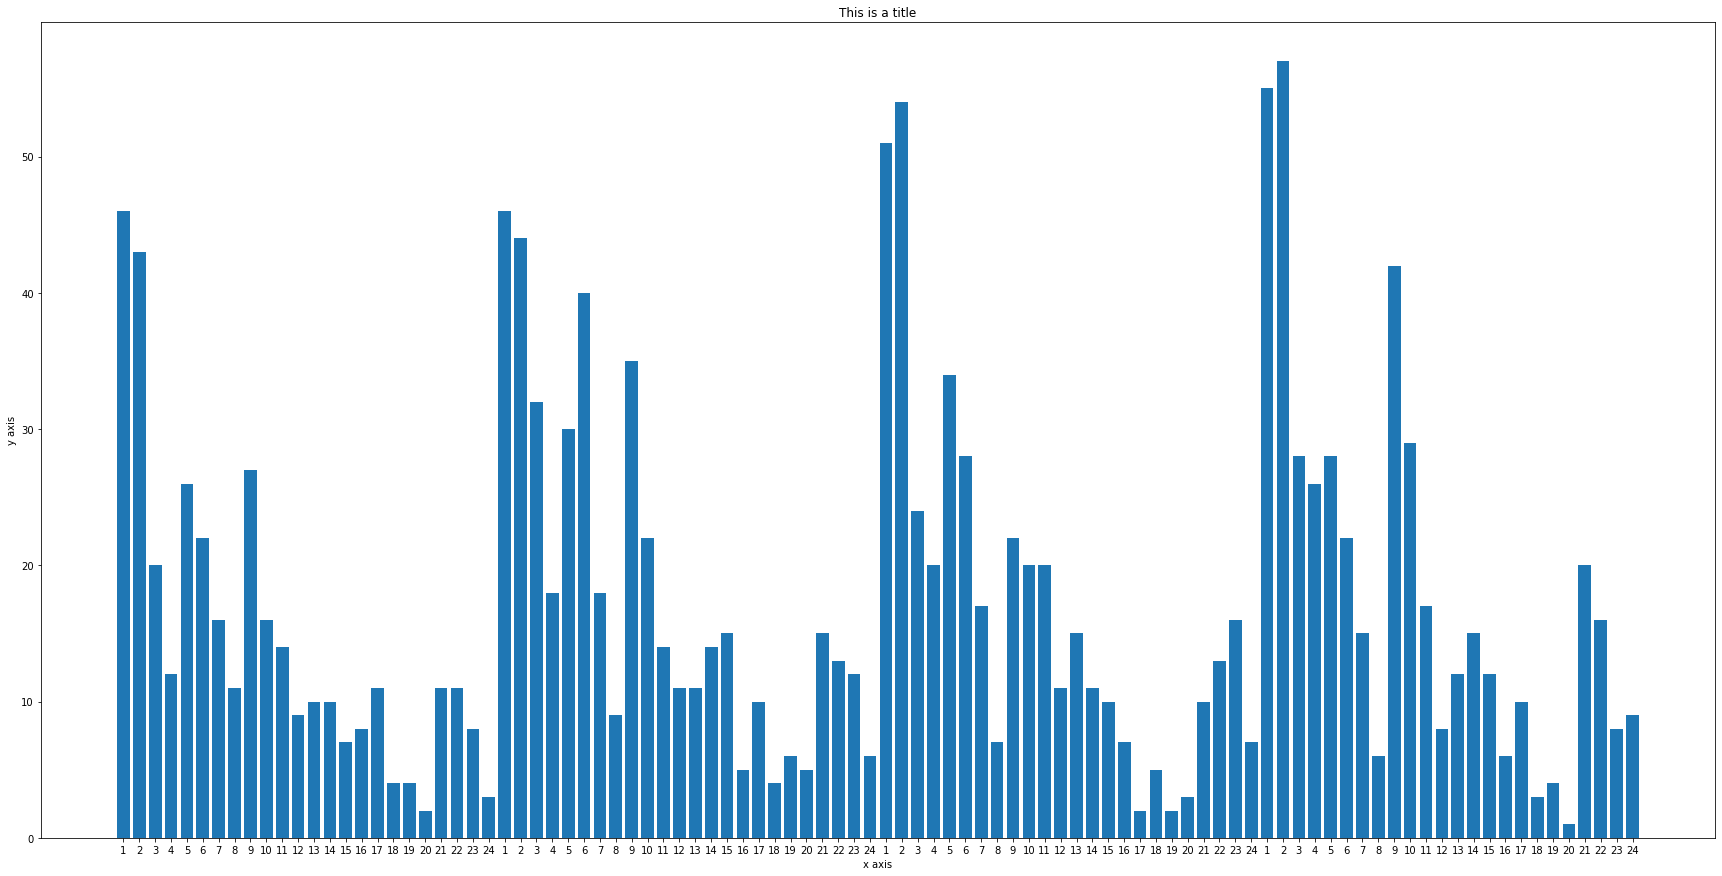

In [16]:

graph_df=season_df.loc[2019, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2018

Text(0, 0.5, 'y axis')

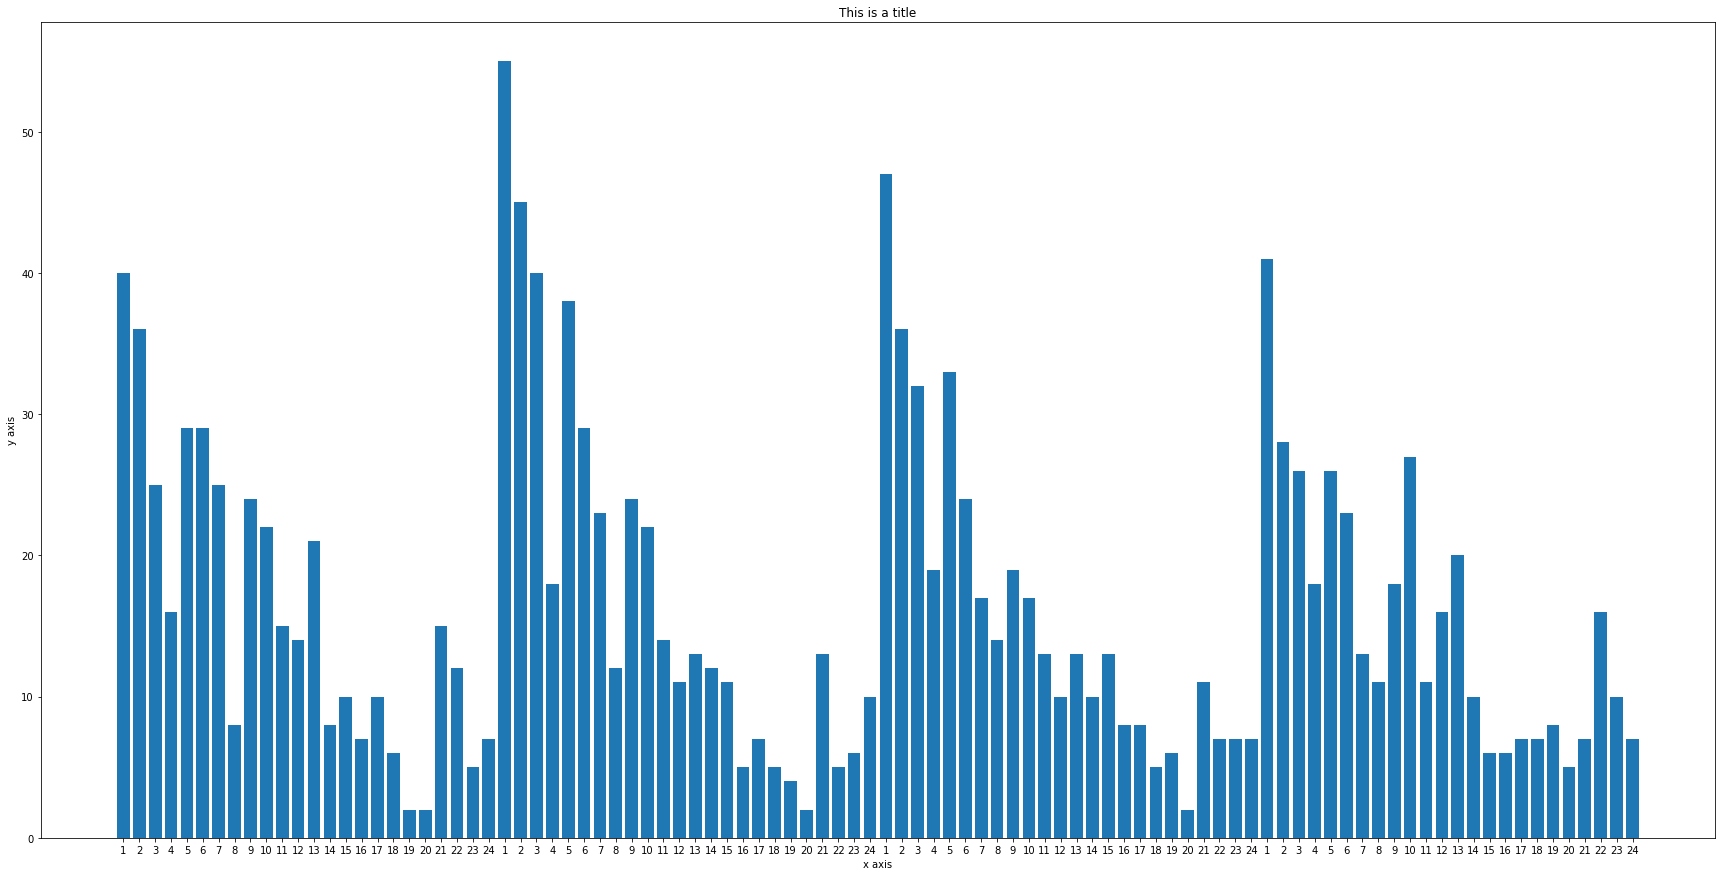

In [17]:

graph_df=season_df.loc[2018, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2017

Text(0, 0.5, 'y axis')

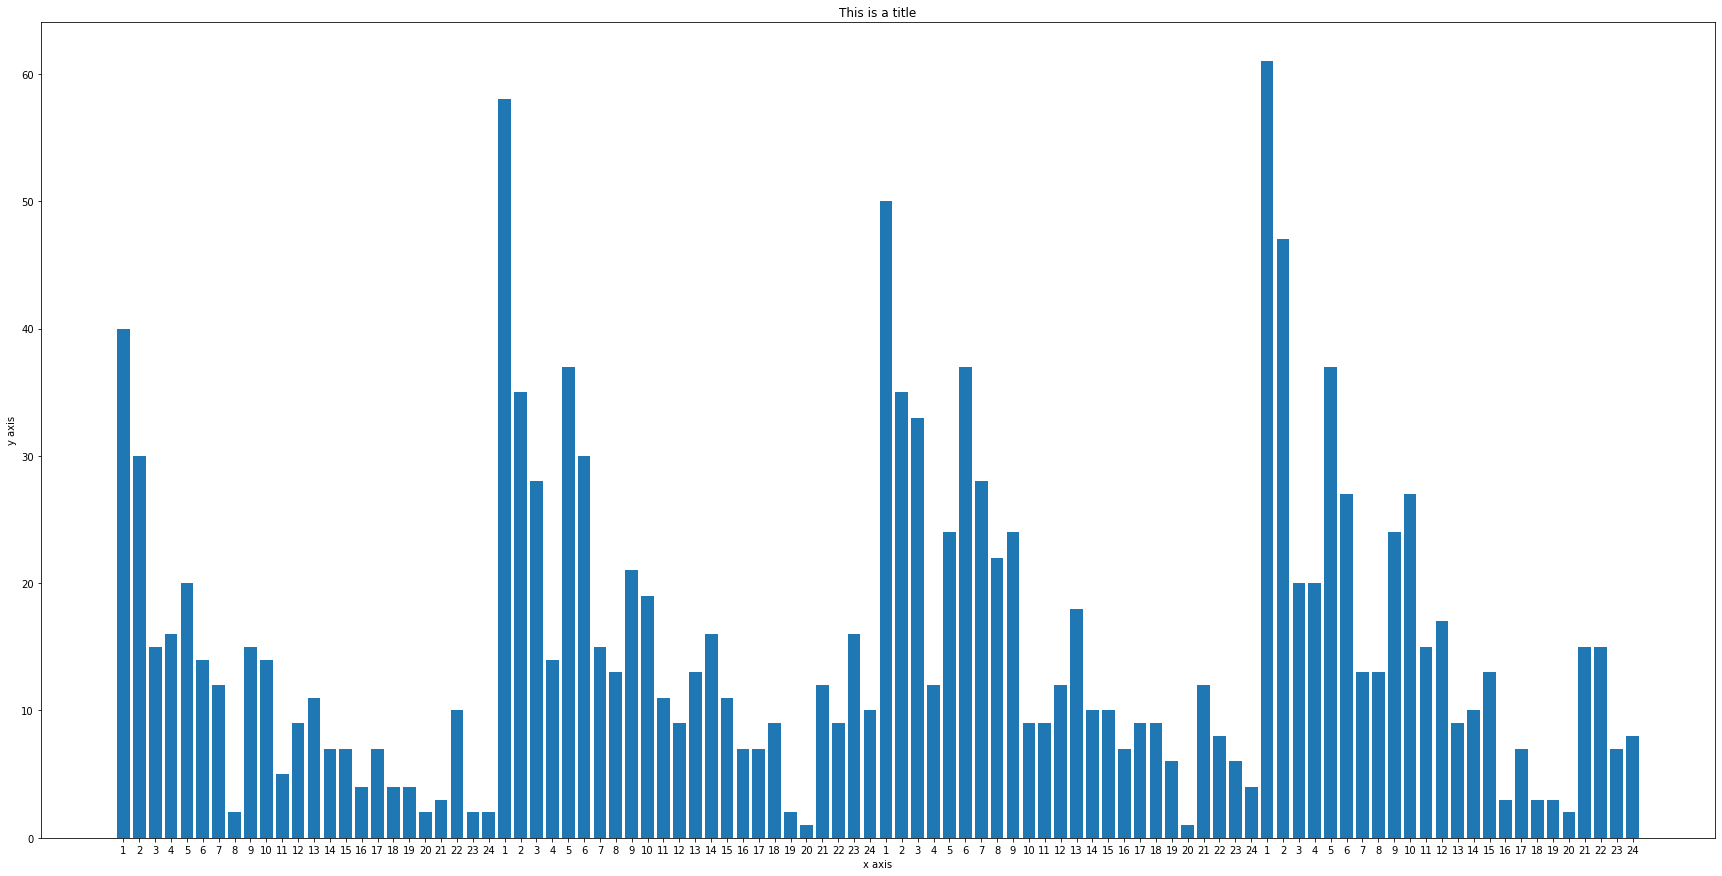

In [18]:

graph_df=season_df.loc[2017, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

#### 2015

ValueError: shape mismatch: objects cannot be broadcast to a single shape

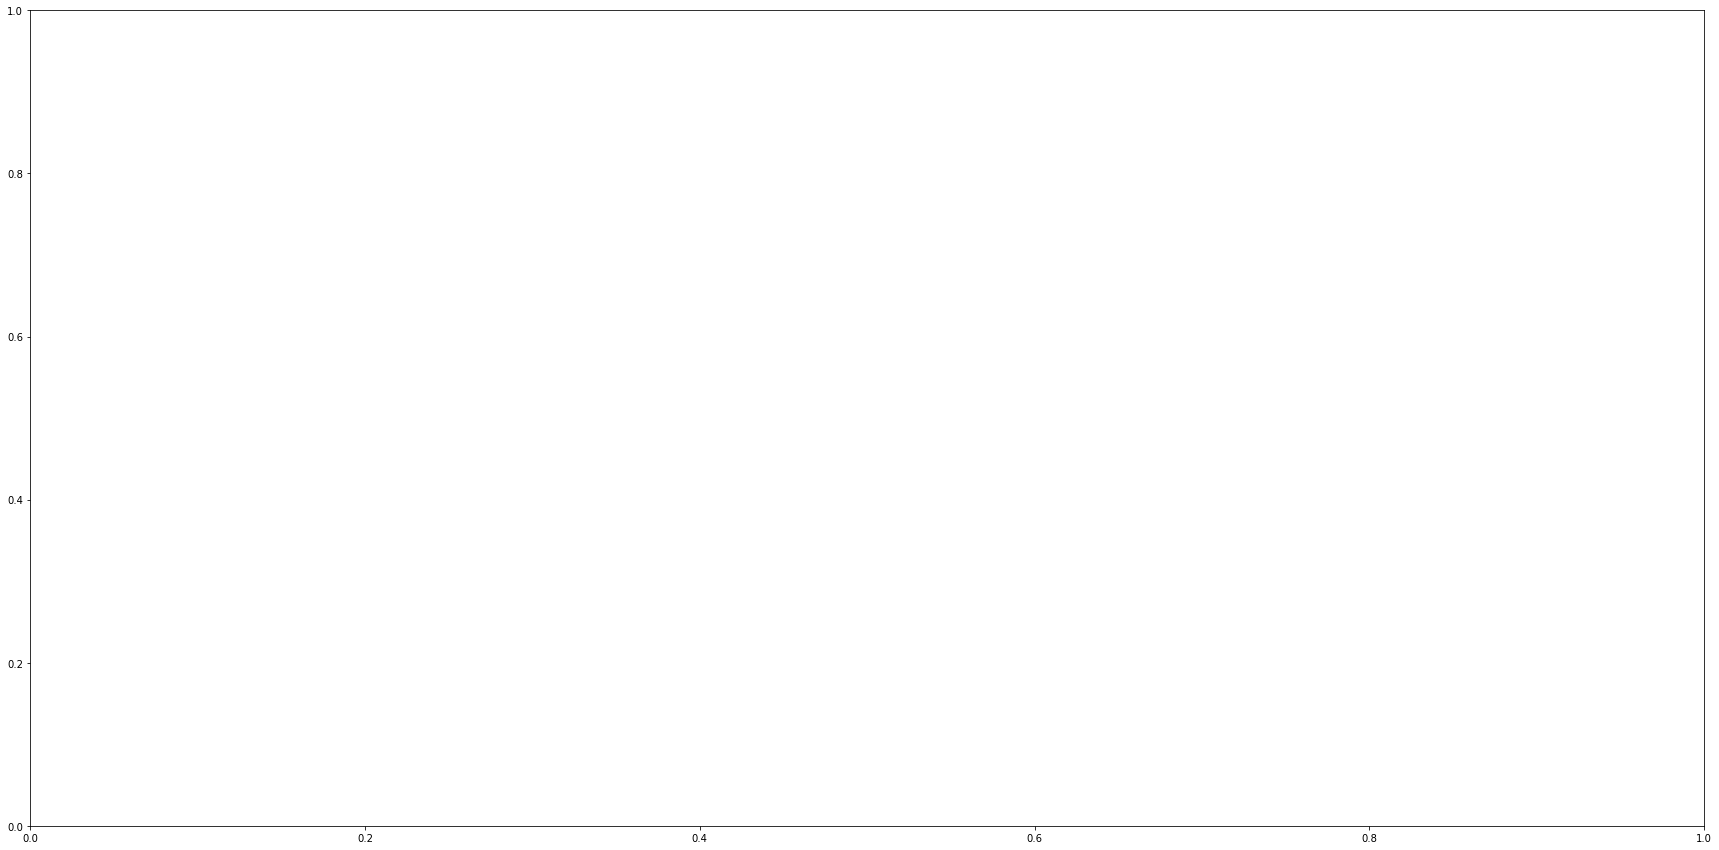

In [19]:

graph_df=season_df.loc[2015, :]

plt.figure(figsize=(30,15))
#Xラベル作成

x=[]
for i in range(4):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

# 季節　結果:

In [ ]:

graph_df=group_year_df.loc[2015:2019, :]
graph_df
plt.figure(figsize=(30,15))
#Xラベル作成
x=[]
for i in range(5):
    for num in graph_df['date'].index.levels[1]:
        x.append(num)
        
y = graph_df['date'].values

plt.bar(np.arange(len(x)), y, tick_label=x, align="center")
plt.title("This is a title")
plt.xlabel("x axis")
plt.ylabel("y axis")

In [ ]:
group_season_df['date'].index.levels[2]

In [ ]:
#train_df.to_csv('test.csv',encoding='utf-8')